## Data 설명
* store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
* card_id : 카드 번호의 hash 값
* card_company : 카드사
* transacted_date : 거래일자
* transacted_time : 거래시간
* installment_term : 할부 개월 수. 일시불은 0
* region : 지역
* type_of_business : 업종
* amount : 매출 금액, 음수인 경우 취소 거래

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
path = './data/'
train = pd.read_csv(path + 'funda_train.csv')
submission  = pd.read_csv(path + 'submission.csv')

## Check Simple EDA

In [3]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


### 유니크 개수 파악

In [4]:
print('train.csv길이',train.shape[0])
print('상점아이디의 개수', train.store_id.nunique())
print('카드 개수', train.card_id.nunique())
print('카드회사의 개수', train.card_company.nunique())
print('지역종류 개수', train.region.nunique())
print('업종종류 개수', train.type_of_business.nunique())

train.csv길이 6556613
상점아이디의 개수 1967
카드 개수 3950001
카드회사의 개수 8
지역종류 개수 180
업종종류 개수 145


### 날짜
* 주기적으로 특정일자에 매출이 감소함

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


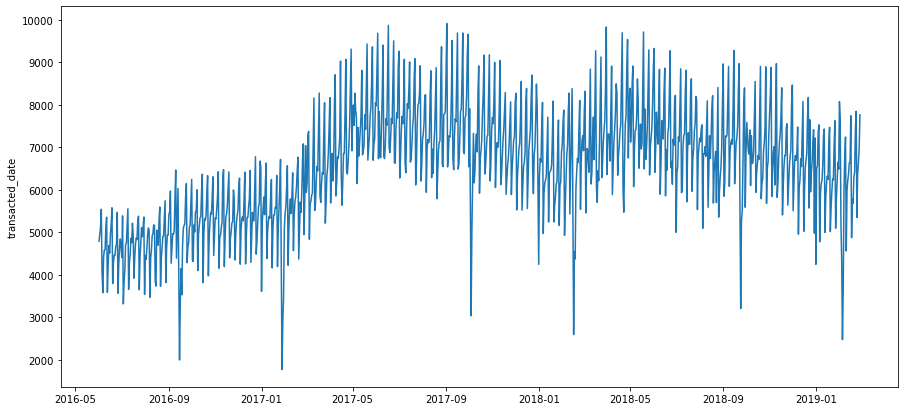

In [5]:
#object -> datetime으로 전환
dates = pd.to_datetime(train.transacted_date)
dates = dates.value_counts().sort_index()

plt.figure(figsize=(15,7))
sns.lineplot(x = dates.index, y = dates)
plt.show()

### 요일
* 0이 월요일이고, 6이 일요일
* 금토에 소비횟수가 가장많고, 일요일이 가장 소비횟수가 적음

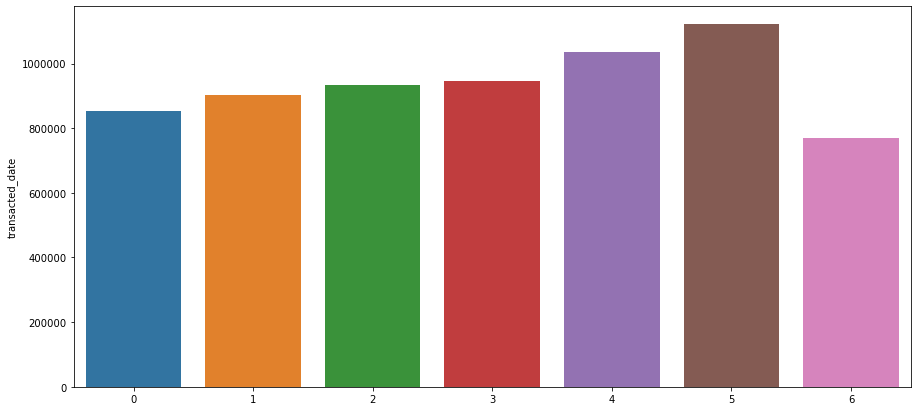

In [23]:
dates = pd.to_datetime(train.transacted_date)
weeks = dates.apply(lambda x : x.weekday())

weeks = weeks.value_counts().sort_index()
plt.figure(figsize=(15,7))
sns.barplot(x = weeks.index, y = weeks)
plt.show()

### time
* 오전 시간대 매출이 가장 적고, 그다음은 14-16시 이전이다

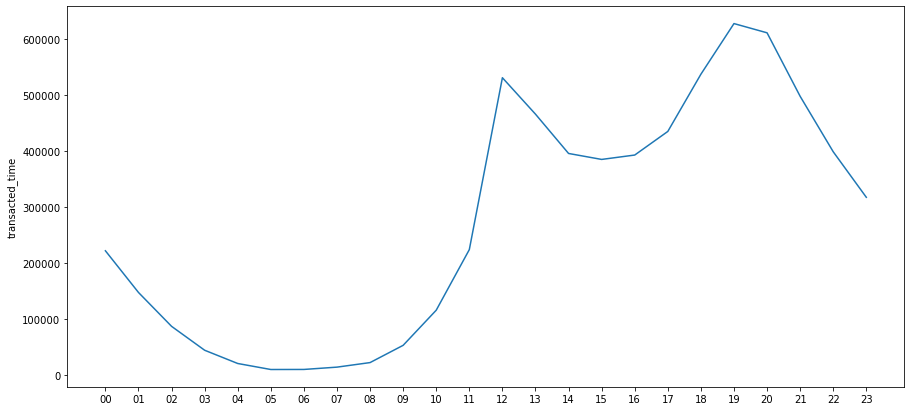

In [6]:
hours = train.transacted_time.apply(lambda x :x[:2])
hours = hours.value_counts().sort_index()

plt.figure(figsize = (15,7))
sns.lineplot(x = hours.index, y = hours)
plt.show()

### installment_term
* 일시불의 비율이 96%이상, 할부의 비중은 1년이하가 가장많다

In [7]:
train['installment_cut'] = 0
train.loc[(train.installment_term>0)&(train.installment_term<13),'installment_cut'] = 1  #1~12개월
train.loc[(train.installment_term>12)&(train.installment_term<25),'installment_cut'] = 2 #12~24개월
train.loc[(train.installment_term>24)&(train.installment_term<37),'installment_cut'] = 3 #24~36개월
train.loc[(train.installment_term>36),'installment_cut'] = 4

In [8]:
train['installment_cut'].value_counts(normalize=True)

0    0.965076
1    0.034541
4    0.000214
2    0.000157
3    0.000012
Name: installment_cut, dtype: float64

### type_of_business
* 횟수별 상위 5위 업종 ['한식 음식점업', '두발 미용업', '의복 소매업', '기타 주점업', '치킨 전문점']
* 최대금액 상위 5위 업종 ['한식 음식점업', '의복 소매업', '의약품 도매업', '일반 교과 학원', '두발 미용업']
* 평균금액 상위 5위 업종 ['의약품 도매업', '기타 산업용 농산물 도매업', '경영 컨설팅업', '일반 병원','주방용품 및 가정용 유리, 요업 제품 소매업']

In [9]:
sample = train.groupby('type_of_business')['amount'].agg(["count","sum","mean"])

In [10]:
sample.sort_values('count',ascending = False).head(5)

,count,sum,mean
type_of_business,,,
한식 음식점업,745905,4.810450e+09,6449.145893
두발 미용업,178475,1.087475e+09,6093.148352
의복 소매업,158234,2.403674e+09,15190.629058
기타 주점업,102413,6.958372e+08,6794.422451
치킨 전문점,89277,3.101811e+08,3474.366893


In [11]:
sample.sort_values('sum',ascending = False).head(5)

,count,sum,mean
type_of_business,,,
한식 음식점업,745905,4.810450e+09,6449.145893
의복 소매업,158234,2.403674e+09,15190.629058
의약품 도매업,4423,1.568540e+09,354632.638674
일반 교과 학원,26745,1.293611e+09,48368.324205
두발 미용업,178475,1.087475e+09,6093.148352


In [12]:
sample.sort_values('mean',ascending = False).head(5)

,count,sum,mean
type_of_business,,,
의약품 도매업,4423,1.568540e+09,354632.638674
기타 산업용 농산물 도매업,1153,3.189488e+08,276625.139388
경영 컨설팅업,631,9.516713e+07,150819.538148
일반 병원,2668,3.609477e+08,135287.727565
"주방용품 및 가정용 유리, 요업 제품 소매업",551,5.284146e+07,95901.011149
